In [42]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../../rule_lib')
sys.path.insert(1, '../../../../notes/1-Testing/fuzzy-test/python/')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [43]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../../tuning-results-pause-during-examples/data-cluster-dont-pause/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    print(f"Processing {directory}")

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # check if tuning and liveInfo files are present
    for time, pair in data_pairs.items():
        if pair[0] is None or pair[1] is None:
            print(f"Missing file for {directory} at time {time}")
            continue

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        assert len(corresponding_liveInfo) == len(
            tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # convert tuningData timings into percentages
        maxTime = tuningData["Reduced"].max()
        tuningData.insert(1, "PerformancePercentage", (
            tuningData["Reduced"] / maxTime) * 100)

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

Processing ../../../tuning-results-pause-during-examples/data-cluster-dont-pause/falling_drop_2
Processing ../../../tuning-results-pause-during-examples/data-cluster-dont-pause/falling_drop_1
Processing ../../../tuning-results-pause-during-examples/data-cluster-dont-pause/exploding_liquid_2
Processing ../../../tuning-results-pause-during-examples/data-cluster-dont-pause/exploding_liquid_1
Processing ../../../tuning-results-pause-during-examples/data-cluster-dont-pause/spinodal_decomp_2
Processing ../../../tuning-results-pause-during-examples/data-cluster-dont-pause/spinodal_decomp_equilibration_1
Processing ../../../tuning-results-pause-during-examples/data-cluster-dont-pause/spinodal_decomp_equilibration_2
Processing ../../../tuning-results-pause-during-examples/data-cluster-dont-pause/spinodal_decomp_1


In [44]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(46430, 29)

In [45]:
df.describe()

avgParticlesPerCell        cutoff   domainSizeX   domainSizeY  \
count         4.643000e+04  46430.000000  46430.000000  46430.000000   
mean          1.800276e+14      2.612643     42.908000     41.923722   
std           1.302795e+15      0.337734     11.422805     10.486611   
min           3.958300e-02      2.000000     15.000000     29.561231   
25%           2.194635e+00      2.500000     45.750000     29.561231   
50%           2.577781e+00      2.500000     46.250000     45.750000   
75%           6.829864e+00      3.000000     49.561231     46.250000   
max           9.607679e+15      3.000000     49.561231     60.000000   

        domainSizeZ  estimatedNumNeighborInteractions   homogeneity  \
count  46430.000000                      4.643000e+04  46430.000000   
mean      38.417177                      4.916827e+05      0.283141   
std       10.277960                      2.721216e+05      0.125933   
min       15.000000                      1.338300e+04      0.080979   
25%       37.296003                      2.796540e+05      0.187408   
50%       37.296003                      5.430290e+05      0.306223   
75%       45.750000                      7.548960e+05      0.409203   
max       46.250000                      1.122188e+06      0.536758   

         maxDensity  maxParticlesPerCell  minParticlesPerCell  ...  \
count  46430.000000         46430.000000              46430.0  ...   
mean       1.070926            23.283244                  0.0  ...   
std        0.337814            13.041312                  0.0  ...   
min        0.463957             7.000000                  0.0  ...   
25%        0.772866            12.000000                  0.0  ...   
50%        1.088394            18.000000                  0.0  ...   
75%        1.354086            38.000000                  0.0  ...   
max        2.044946            54.000000                  0.0  ...   

       particleSizeNeededByFunctor  particlesPerBlurredCellStdDev  \
count                      46430.0                   46430.000000   
mean                          72.0                       0.306401   
std                            0.0                       0.302579   
min                           72.0                       0.005625   
25%                           72.0                       0.140208   
50%                           72.0                       0.244160   
75%                           72.0                       0.260963   
max                           72.0                       5.331309   

       particlesPerCellStdDev  rebuildFrequency          skin   threadCount  \
count            46430.000000      46430.000000  46430.000000  46430.000000   
mean                 0.049776         11.525953      1.403791     13.800000   
std                  0.066912          2.302465      1.093088     10.665948   
min                  0.006075         10.000000      0.200000      1.000000   
25%                  0.022822         10.000000      0.500000      4.000000   
50%                  0.033604         10.000000      1.000000     12.000000   
75%                  0.035240         15.000000      3.000000     24.000000   
max                  1.105479         15.000000      3.000000     28.000000   

       PerformancePercentage  CellSizeFactor       Reduced      Smoothed  
count           46430.000000         46430.0  4.643000e+04  4.643000e+04  
mean               33.319199             1.0  8.292302e+07  8.011640e+07  
std                22.350011             0.0  9.017730e+07  8.737212e+07  
min                 4.028222             1.0  9.973890e+05  9.973890e+05  
25%                16.236249             1.0  2.834012e+07  2.792465e+07  
50%                26.307919             1.0  5.289612e+07  5.189006e+07  
75%                43.481770             1.0  1.097719e+08  1.033263e+08  
max               100.000000             1.0  6.492644e+08  6.492644e+08  

[8 rows x 25 columns]

In [46]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Define Interesting Data to observe


In [47]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

In [48]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Filter Data / Outliers


In [49]:
# only keep rows where performance percentage is above x
dffiltered = df[df["PerformancePercentage"] >= 70]


def combine_columns(row):
    return ", ".join(sorted(map(str, list(np.unique(row)))))


# group data on input columns and concatenate output columns
dfgrouped = dffiltered.groupby(inputs).agg(combine_columns).reset_index()

# remove columns that are not needed
dfgrouped.drop(columns=["Reduced", "Smoothed",
               "PerformancePercentage"], inplace=True)


# Remove any rows where a numerical colum lies outside 3 standard deviations
z = np.abs(stats.zscore(dfgrouped.select_dtypes(include=[np.number])))
dfgrouped = dfgrouped[(z < 3).all(axis=1)]


X, y =dfgrouped[inputs], dfgrouped[outputs]

print(X.shape, y.shape)

(4152, 6) (4152, 3)


# Create Train and Test Data


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [51]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  maxParticlesPerCell  \
3455             6.829864     0.410784    1.354086                   37   
1098             3.705496     0.329443    1.194579                   19   
2489             3.935997     0.087762    0.600415                   11   
1843             3.935559     0.088180    0.627706                   12   
3987             6.829864     0.430085    1.519892                   40   

      particlesPerCellStdDev  threadCount    Container_DataLayout  \
3455                0.033759            1  VerletClusterLists_AoS   
1098                0.016874           12  VerletClusterLists_AoS   
2489                0.006233           12  VerletClusterLists_AoS   
1843                0.006226           12  VerletClusterLists_AoS   
3987                0.035276           24  VerletClusterLists_AoS   

                  Traversal  Newton 3  
3455       vcl_c01_balanced  disabled  
1098             vcl_sliced  disabled  
2489         vcl_sliced_c02  disabled  
1843         vcl_sliced_c02  disabled  
3987  vcl_cluster_iteration  disabled

In [52]:
for i, col in enumerate(y.columns):

    y_count = y[col].value_counts()

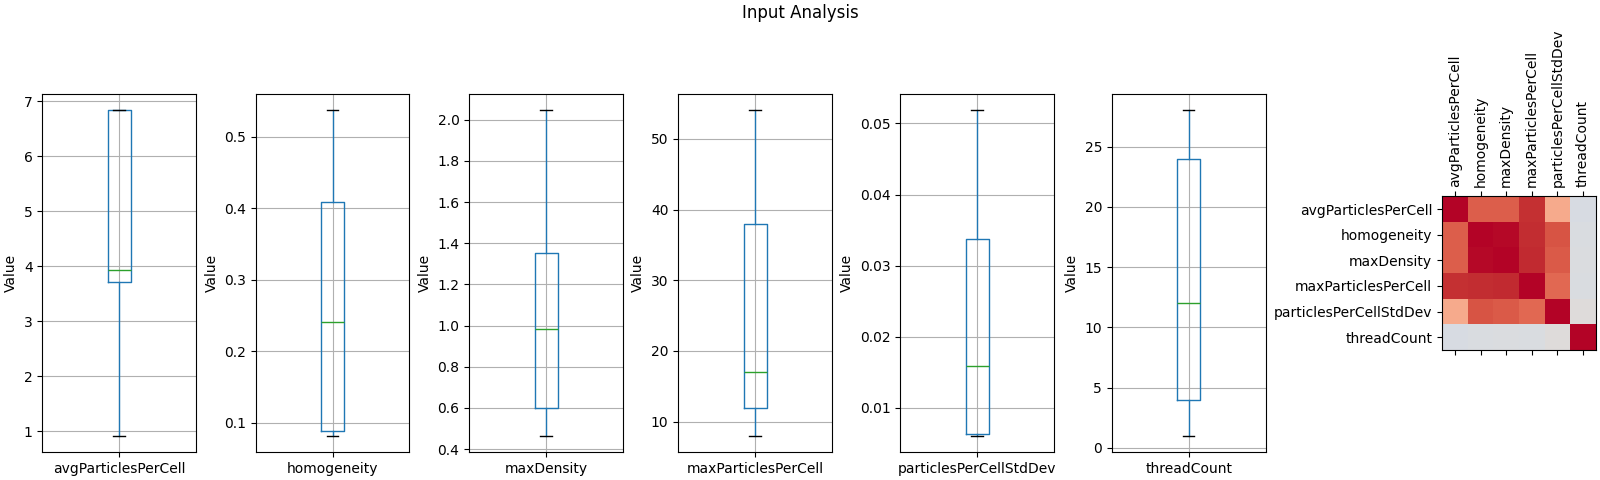

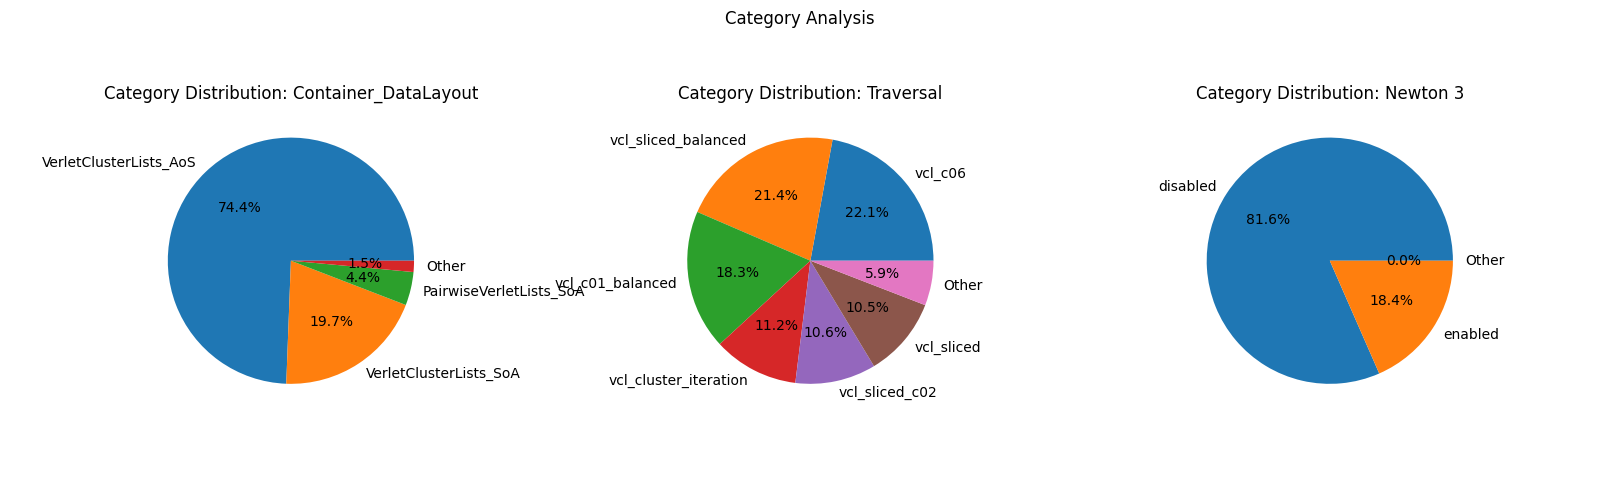

In [53]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns)+1, constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix
corr = X.corr()
cax = ax1[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1[i].set_xticks(range(len(X.columns)))
ax1[i].set_yticks(range(len(X.columns)))
ax1[i].set_xticklabels(X.columns, rotation=90)
ax1[i].set_yticklabels(X.columns)


# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)


for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()

    total = y_count.sum()

    # grouping categories with less than 2% of the total
    y_count_group = y_count[y_count.gt(total*0.02)]
    y_count_group["Other"] = y_count[~y_count.index.isin(
        y_count_group.index)].sum()

    ax1[i].pie(y_count_group, labels=y_count_group.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Train Decision Tree and Extract Rules


In [54]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.05,
    "Traversal": 0.05,
    "Newton 3": 0.05,

}

# maximum depth of the decision tree
MAX_DEPTH = 5

# how many trees should be used to create rules for each label
TOP_K_MODELS_PER_LABEL = 2

Training on 3321 samples
Number of rules 41:
	Container_DataLayout (16 rules)
	Traversal (19 rules)
	Newton 3 (6 rules)


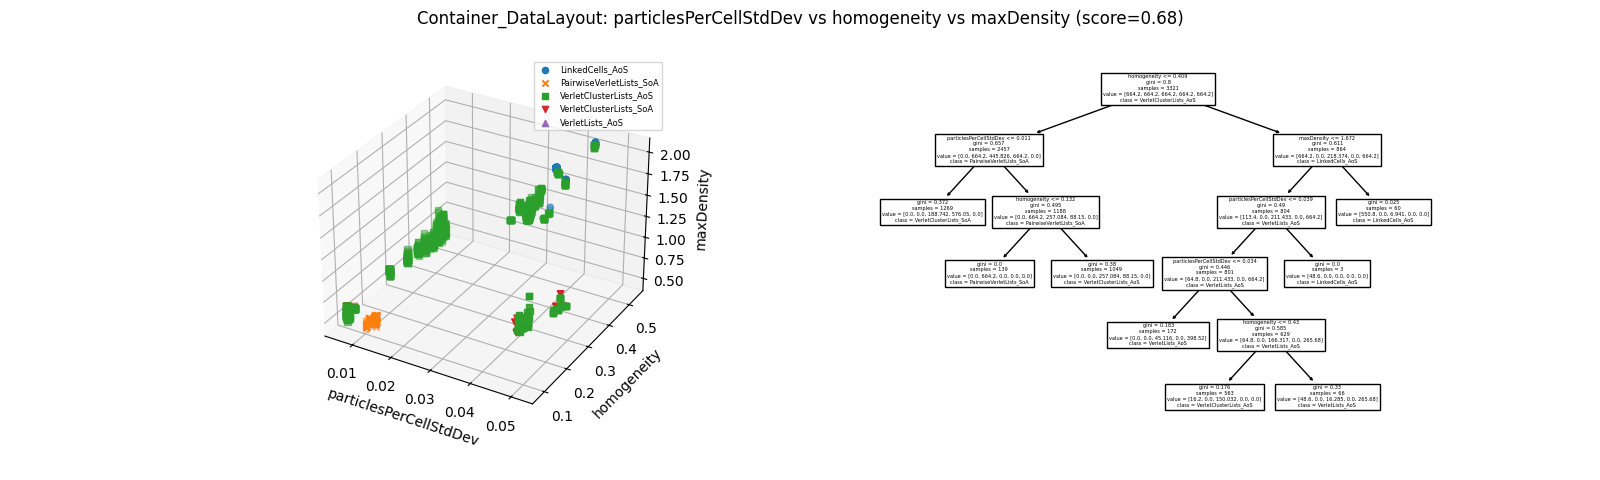

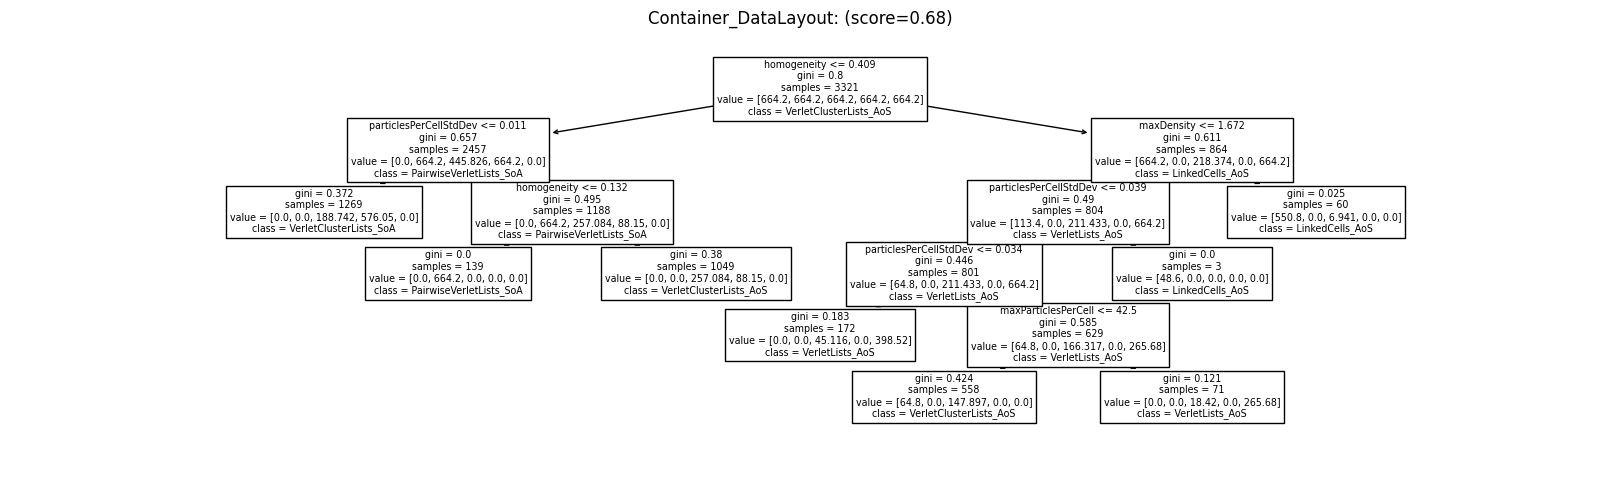

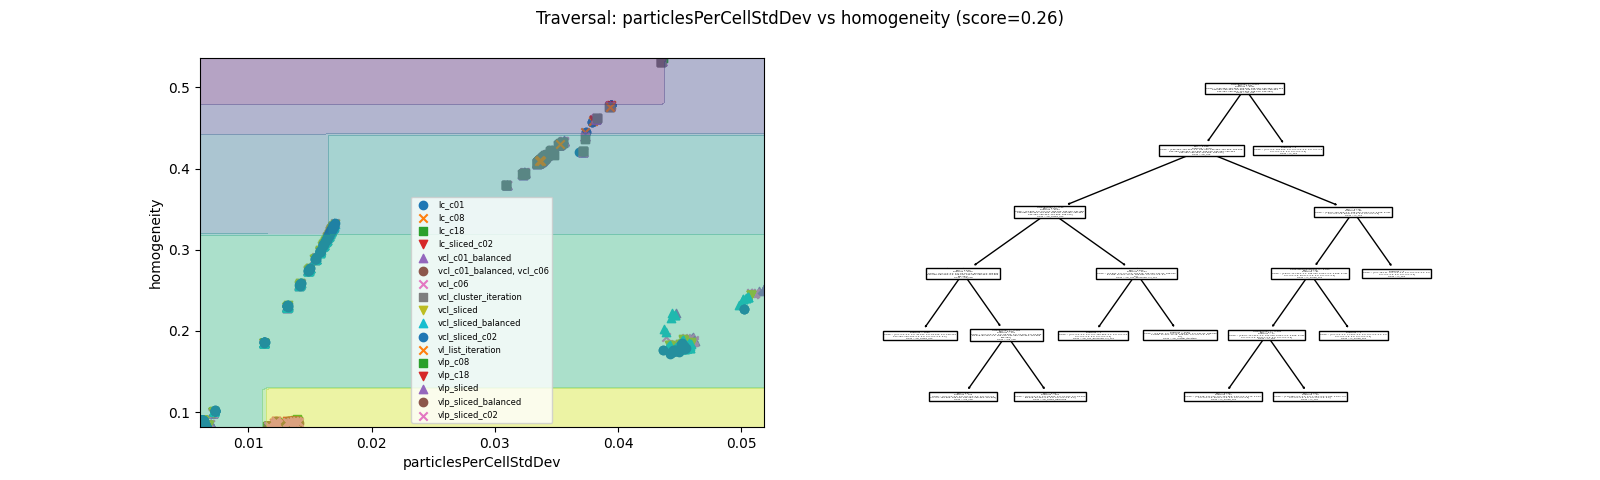

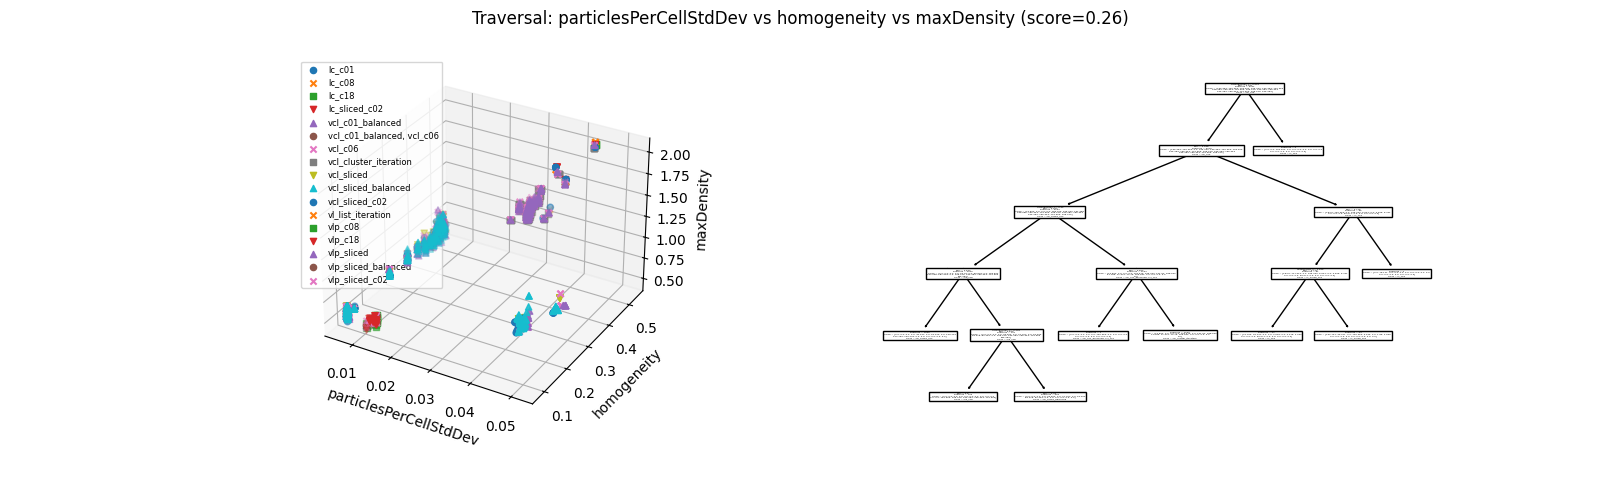

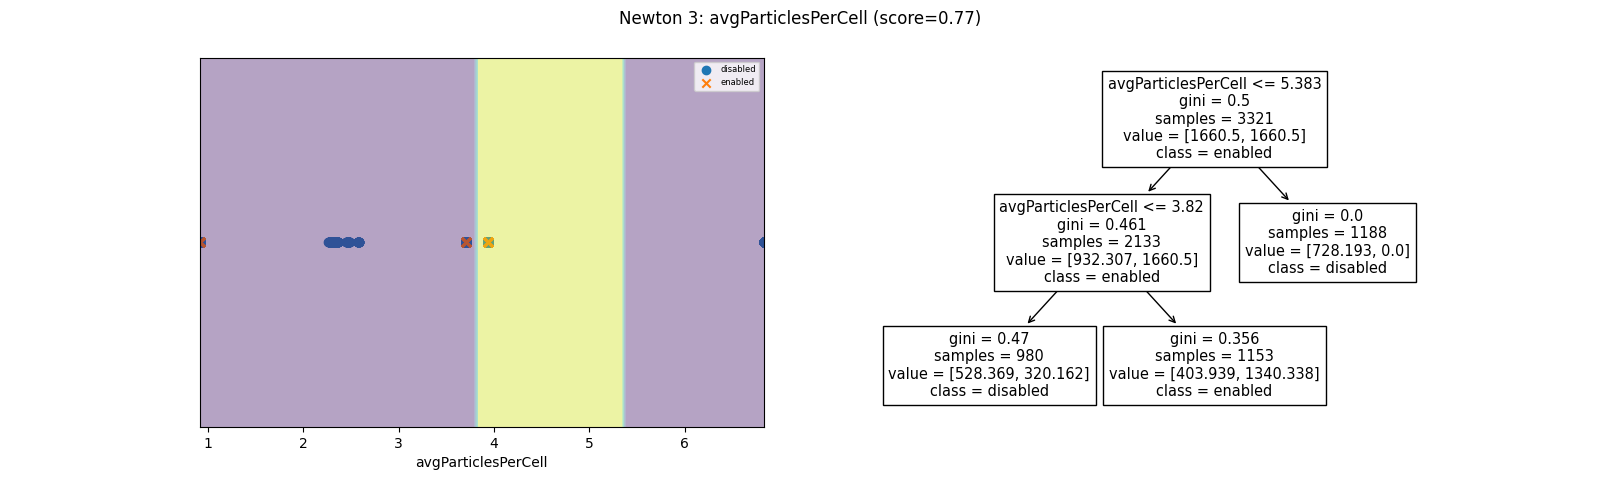

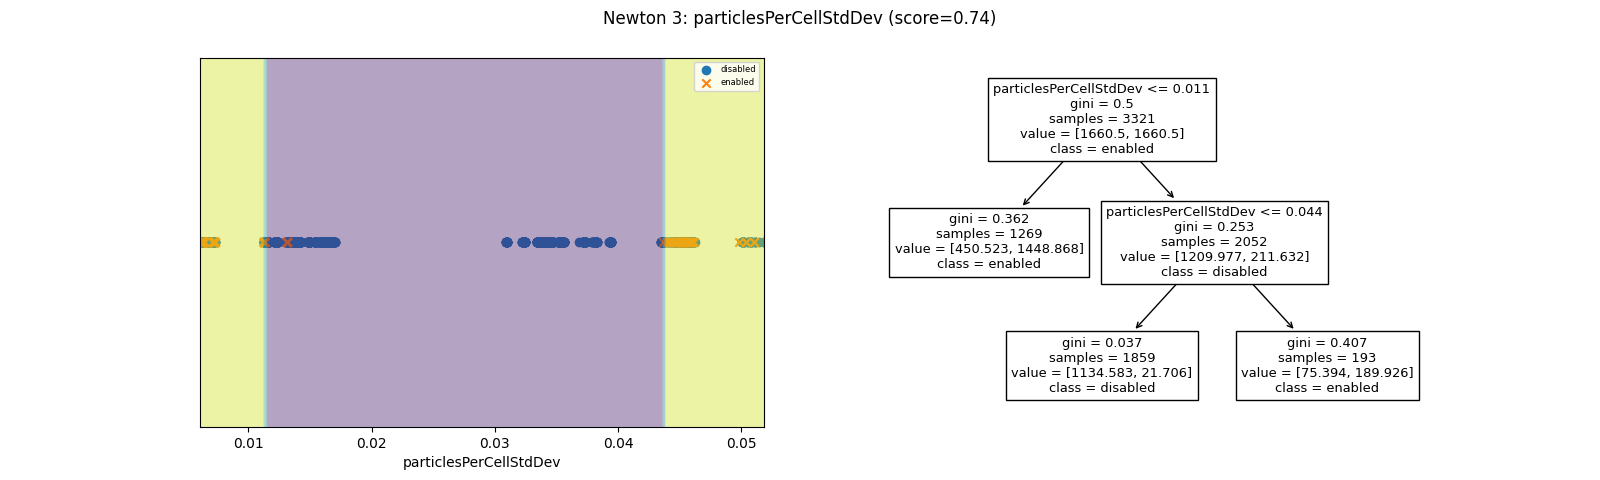

In [55]:
auto_rules = create_auto_rules(X_train, y_train,  None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

/home/manuel/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/manuel/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


homogeneity: [-inf, 0.132, 0.32, 0.409, 0.43, 0.443, 0.478, 0.536, inf]
homogeneity: [-inf, 0.132, 0.32, 0.409, 0.43, 0.478, 0.536, inf]

particlesPerCellStdDev: [-inf, 0.011, 0.017, 0.034, 0.039, 0.044, inf]
particlesPerCellStdDev: [-inf, 0.011, 0.017, 0.034, 0.039, 0.044, inf]

maxDensity: [-inf, 1.672, inf]
maxDensity: [-inf, 1.672, inf]

maxParticlesPerCell: [-inf, 42.5, inf]
maxParticlesPerCell: [-inf, 42.5, inf]

avgParticlesPerCell: [-inf, 3.82, 5.383, inf]
avgParticlesPerCell: [-inf, 3.82, 5.383, inf]



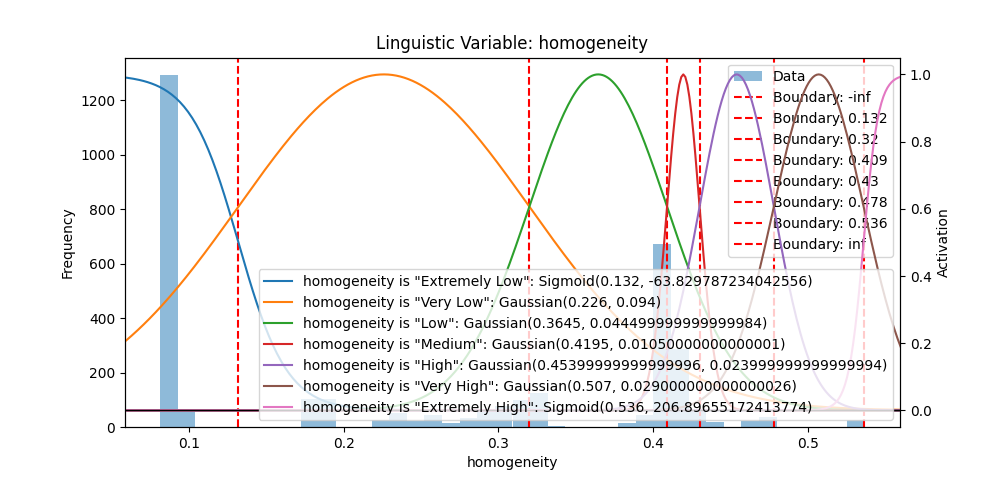

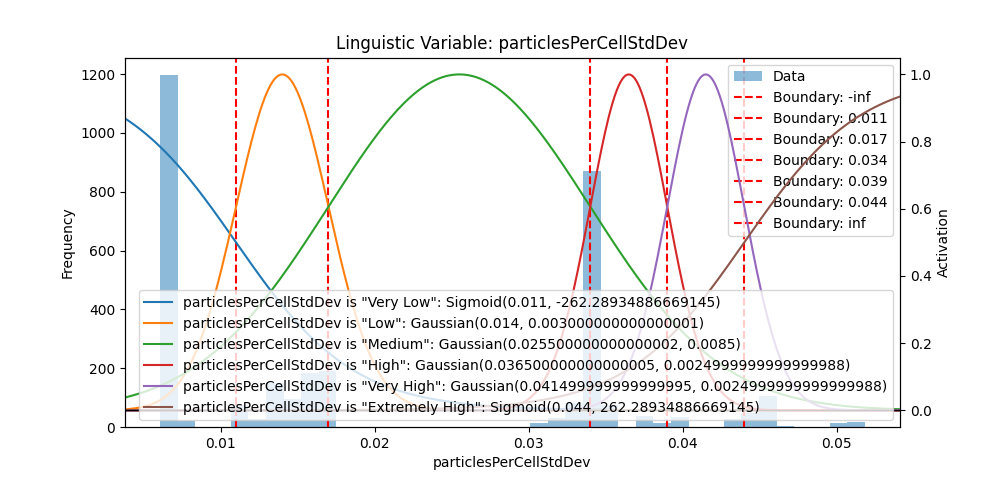

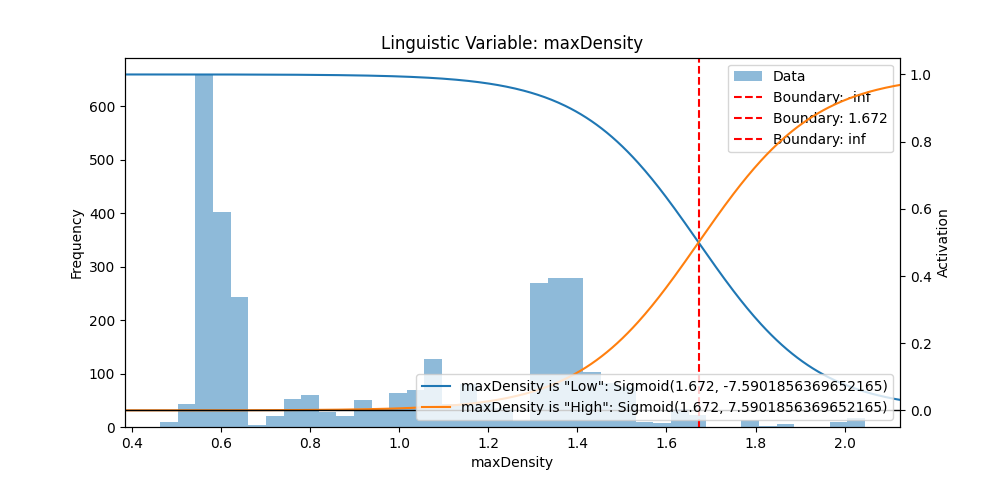

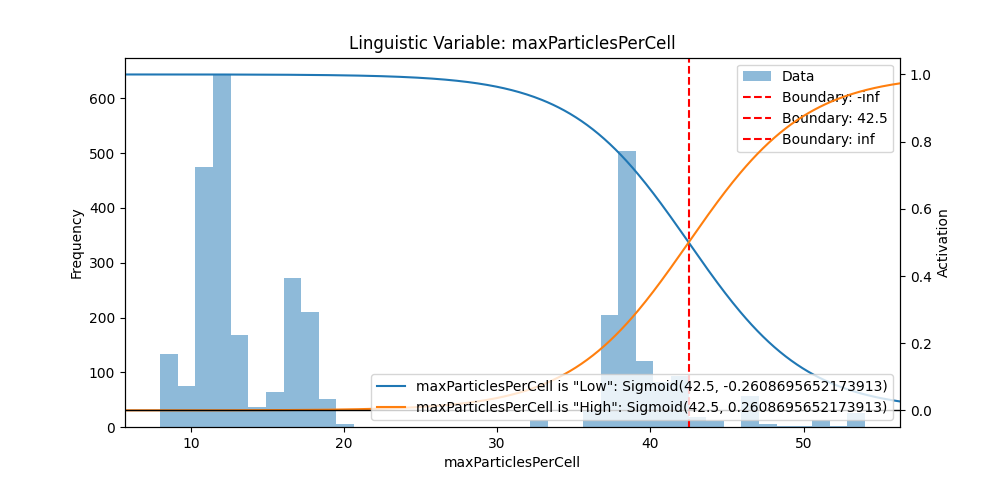

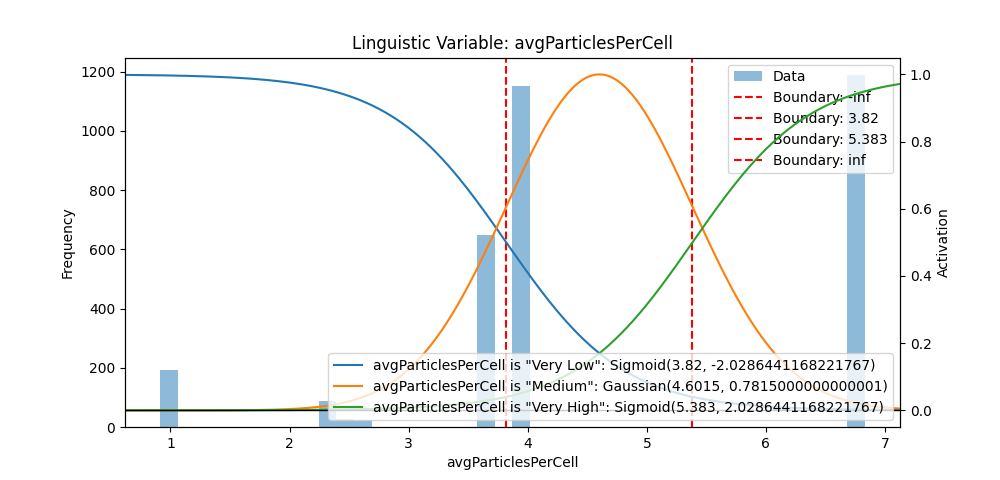

In [56]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


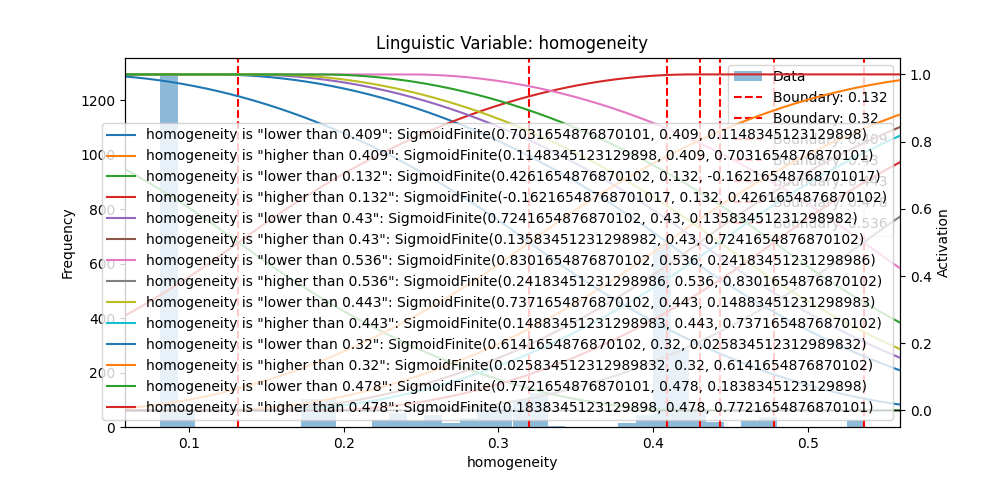

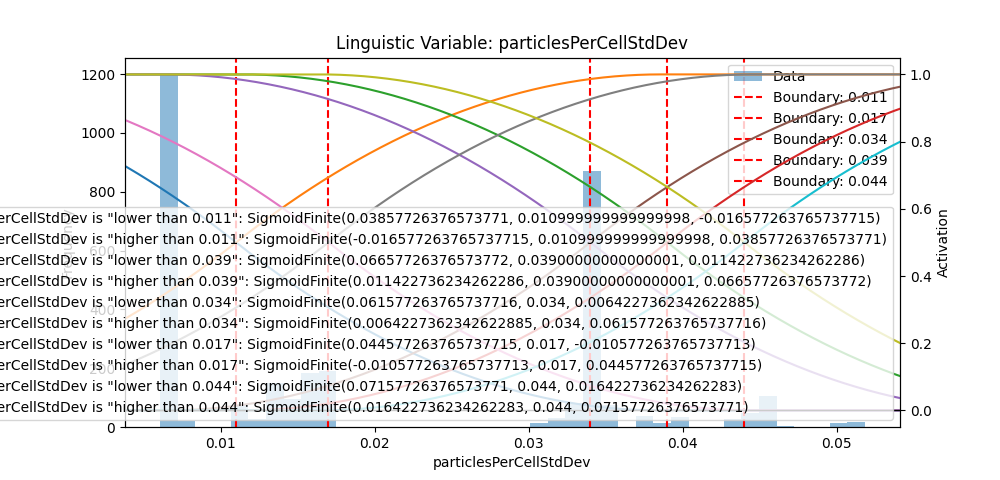

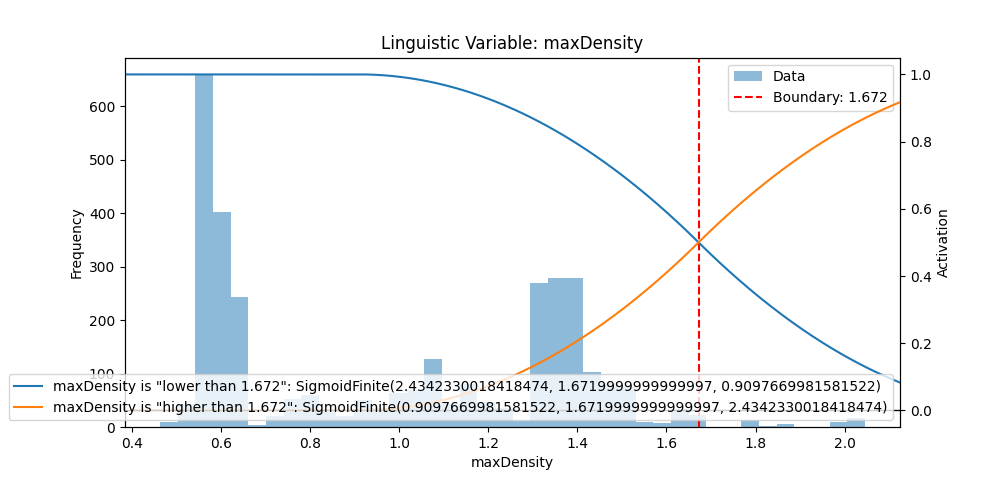

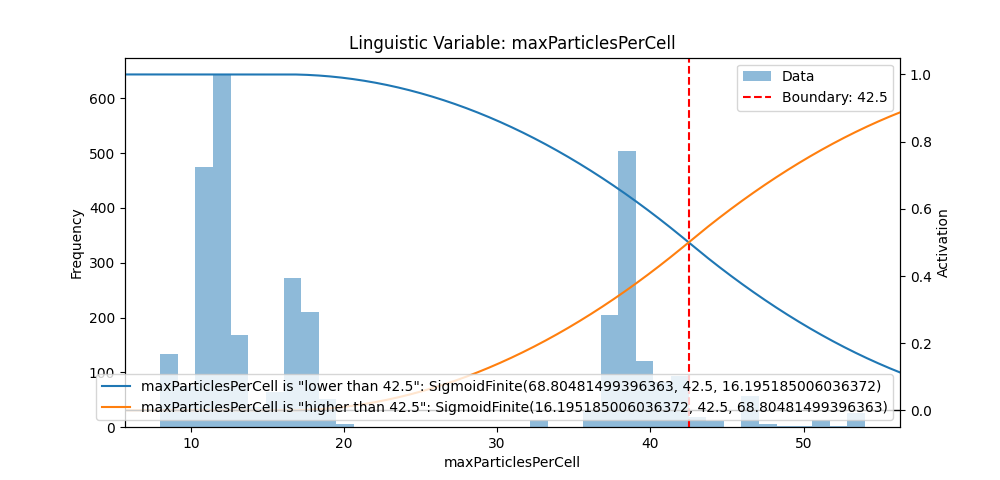

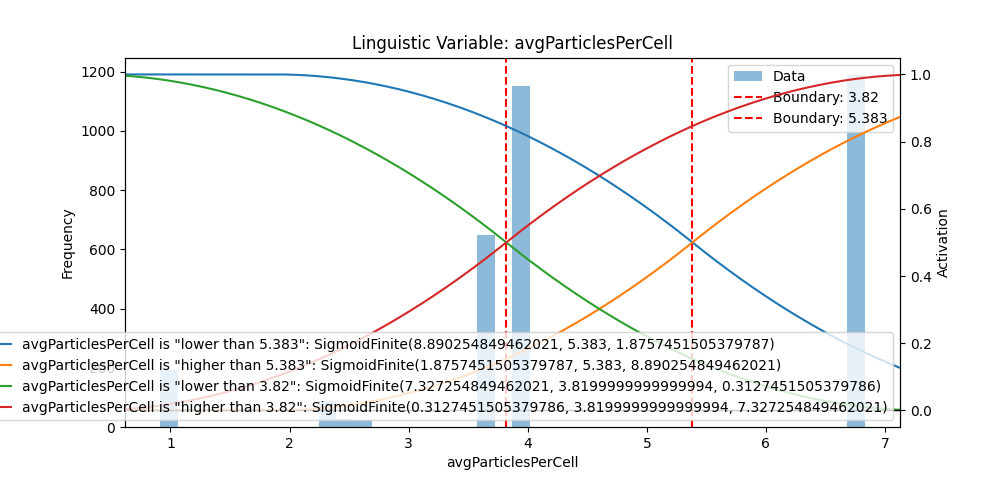

In [57]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

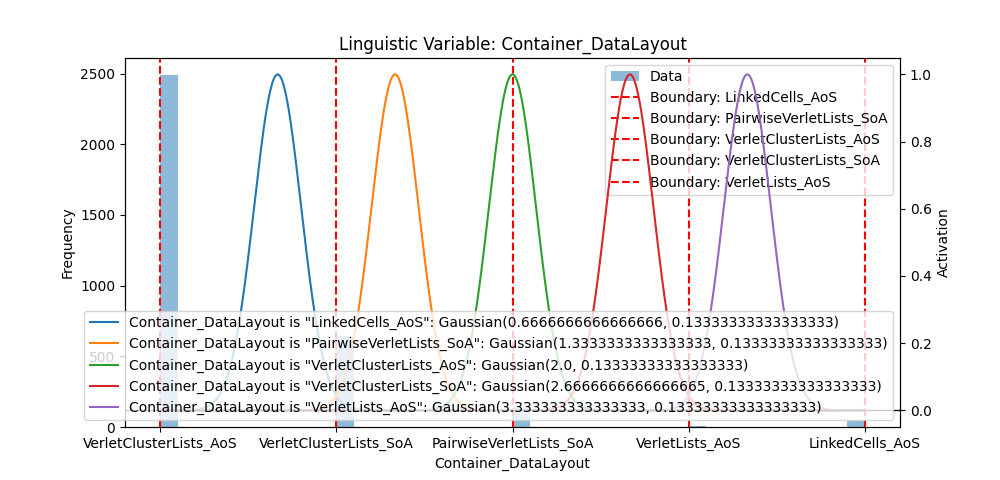

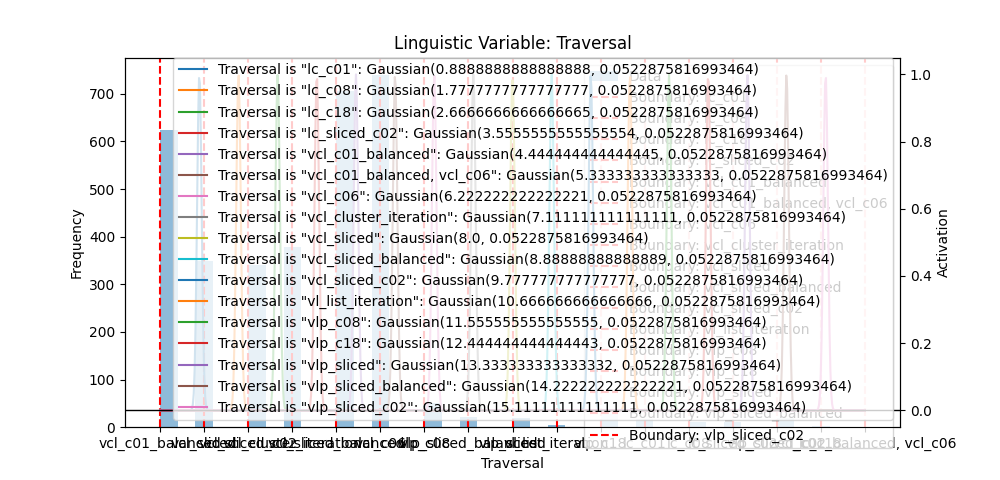

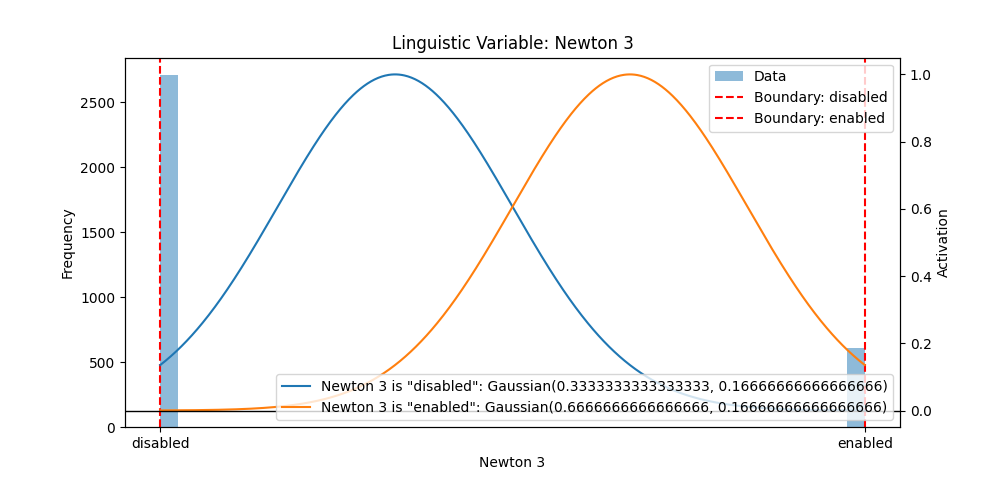

In [58]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

# Save all the data


In [59]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")

FuzzyVariable: domain: "homogeneity" range: (-0.21268548768701018, 0.8309234876870102)
	"Extremely Low": Sigmoid(0.132, -63.829787234042556)
	"Very Low": Gaussian(0.226, 0.094)
	"Low": Gaussian(0.3645, 0.044499999999999984)
	"Medium": Gaussian(0.4195, 0.01050000000000001)
	"High": Gaussian(0.45399999999999996, 0.023999999999999994)
	"Very High": Gaussian(0.507, 0.029000000000000026)
	"Extremely High": Sigmoid(0.536, 206.89655172413774)

FuzzyVariable: domain: "particlesPerCellStdDev" range: (-0.021502263765737713, 0.07940326376573771)
	"Very Low": Sigmoid(0.011, -262.28934886669145)
	"Low": Gaussian(0.014, 0.003000000000000001)
	"Medium": Gaussian(0.025500000000000002, 0.0085)
	"High": Gaussian(0.036500000000000005, 0.0024999999999999988)
	"Very High": Gaussian(0.041499999999999995, 0.0024999999999999988)
	"Extremely High": Sigmoid(0.044, 262.28934886669145)

FuzzyVariable: domain: "maxDensity" range: (-0.2982760018418477, 2.8071790018418477)
	"Low": Sigmoid(1.672, -7.5901856369652165)